In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme()

In [3]:
df = pd.read_csv("iucaa_paper_results_v2.csv")

# 1. Histograms
#### Look at distribution of objects as a function of different features for each true/pred combo 

In [4]:
subdf_dict = {}
for cl in df["class"].unique():
    for cl2 in df["class"].unique():
        idef = f"true={cl},pred={cl2}"
        subdf = df[(df["class"] == cl) & (df["pred_class"] == cl2)]
        subdf_dict[idef] = subdf

In [5]:
# !mkdir "type1/"

In [6]:
interesting_feats = ["dered_r", "deVRad_r", "psffwhm_r", "extinction_r", "u_g", "g_r", "r_i", "i_z"]

for feat_interest in interesting_feats:
    fig, axs = plt.subplots(3, 3, sharex=True, sharey=False, figsize=(12,12))
    print("*"*50,feat_interest,"*"*50,)
    for count,idef in enumerate(subdf_dict):
        i = int(count/3)
        j = int(count % 3)
        ax = axs[i,j]
        subdf = subdf_dict[idef]
#         subdf[feat_interest].hist(ax=ax, bins=100)
        sns.histplot(subdf[feat_interest], ax=ax, kde=True)
        ax.set_xlabel(feat_interest)
        ax.set_ylabel("Count")
        ax.set_title(idef)

    plt.suptitle(feat_interest)
    fig.tight_layout()
    plt.savefig(f"type1/{feat_interest}.pdf")
    plt.show()

# 2. Feature v/s r plots
#### Look at how different features change with increasing r magnitude, for both the train and test set.

In [6]:
r_feats = ["dered_r", "deVRad_r", "psffwhm_r", "extinction_r", "u_g","g_r","r_i","i_z"]

In [7]:
df["r"] = df["dered_r"]+df["extinction_r"]

In [8]:
# !mkdir "type2/"

In [9]:
# for feat_interest in r_feats:
#     x = df["r"]
#     y = df[feat_interest]
#     plt.scatter(x=x, y=y, s=5)
#     plt.xlabel("r")
#     plt.ylabel(feat_interest)
#     plt.title(f"{feat_interest} vs r")
#     plt.savefig(f"type2/{feat_interest}.pdf")
#     plt.show()

In [10]:
train_df = df[df["set"]=="TRAIN"]
test_df = df[df["set"]=="TEST"]

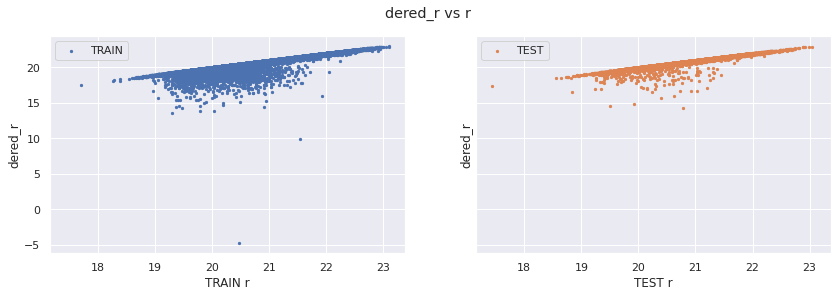

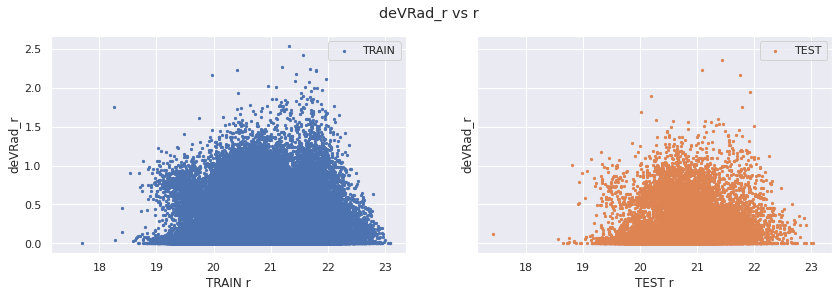

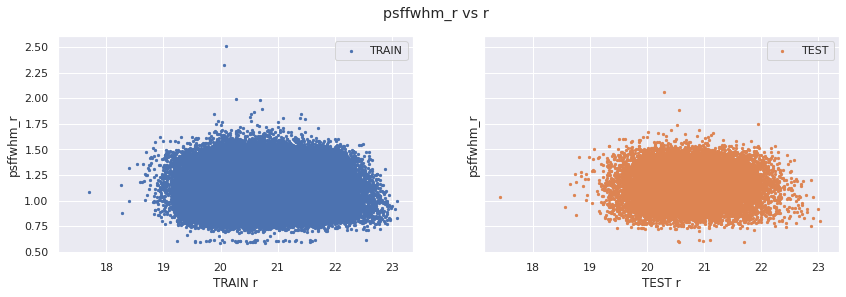

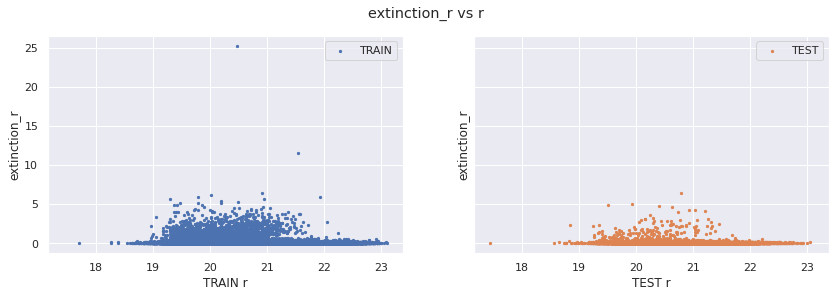

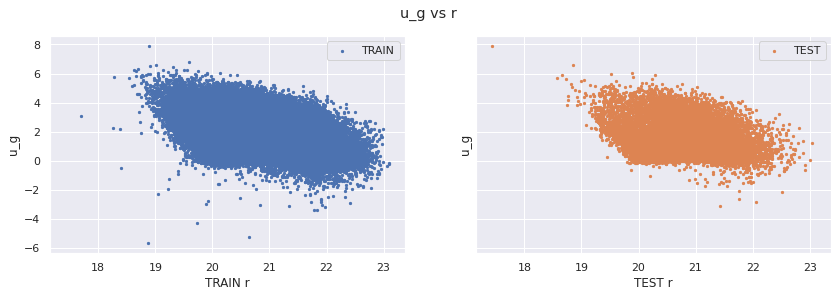

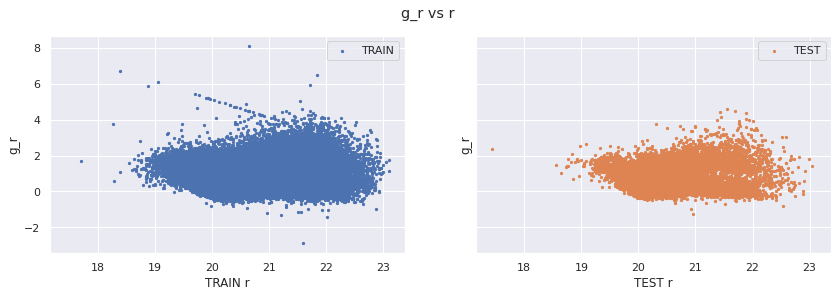

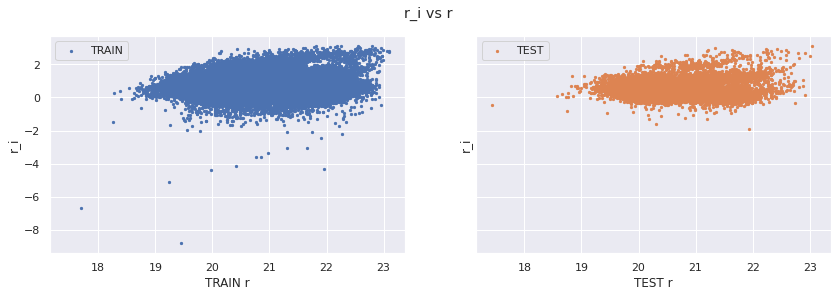

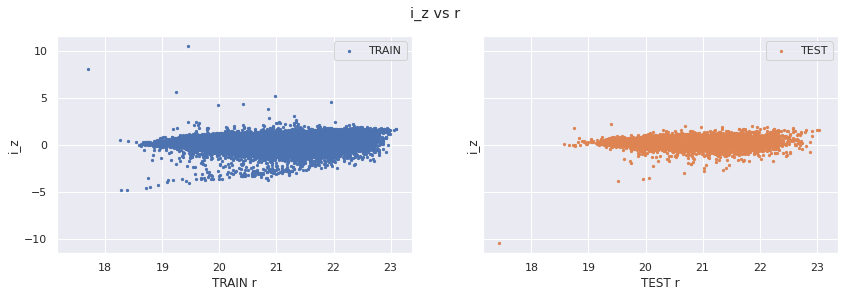

In [22]:
for feat_interest in r_feats:
    x1 = train_df["r"]
    y1 = train_df[feat_interest]
    x2 = test_df["r"]
    y2 = test_df[feat_interest]
    
    fig, (ax1,ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14,4))
    ax1.scatter(x=x1, y=y1, s=5, color=sns.color_palette()[0], label="TRAIN")
    ax1.set_xlabel("TRAIN r")
    ax1.set_ylabel(feat_interest)
    ax1.legend()

    ax2.scatter(x=x2, y=y2, s=5, color=sns.color_palette()[1], label="TEST")
    ax2.set_xlabel("TEST r")
    ax2.set_ylabel(feat_interest)
    ax2.legend()

    plt.suptitle(f"{feat_interest} vs r")
    plt.savefig(f"type2/{feat_interest}.pdf")
    
    plt.show()

# 3. Limit extinction_r for test data
#### Let's look at the test set performance only when 0 < extinction_r < 0.1

In [11]:
!mkdir type3

mkdir: cannot create directory ‘type3’: File exists


In [12]:
test_df = df[df["set"] == "TEST"]

In [13]:
test_df["class"].value_counts()

QSO       5059
STAR      5031
GALAXY    4910
Name: class, dtype: int64

In [14]:
lowextinctiontest_df = test_df[test_df["extinction_r"].between(0, 0.1, inclusive="both")]

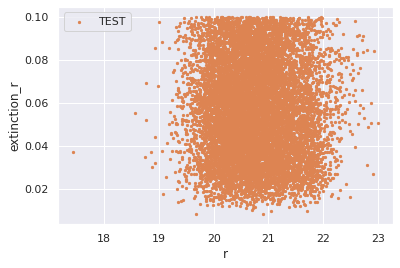

In [15]:
x2 = lowextinctiontest_df["r"]
y2 = lowextinctiontest_df["extinction_r"]

plt.scatter(x=x2, y=y2, s=5, color=sns.color_palette()[1], label="TEST")
plt.xlabel("r")
plt.ylabel("extinction_r")
plt.legend()


In [16]:
y_pred = lowextinctiontest_df["pred_class"].to_numpy()
y_true = lowextinctiontest_df["class"].to_numpy()

In [17]:
from sklearn import metrics

def get_metrics(y_pred, y_test, to_print=True):
    correct_labels = np.where(y_pred==y_test)[0]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred,average='macro')
    recall = metrics.recall_score(y_test, y_pred,average='macro')
    f1score = metrics.f1_score(y_test, y_pred,average='macro')
    # rocscore = metrics.roc_auc_score(y_test, y_pred,average='micro',multi_class="ovo")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)  
    classification_report = metrics.classification_report(y_test, y_pred)

    if to_print:
        print("Identified {} correct labels out of {} labels".format(len(correct_labels), y_test.shape[0]))
        print("Accuracy:",accuracy)
        print("Precision:",precision)
        print("Recall:",recall)
        print("F1 Score:",f1score)
        # print("ROC AUC Score:",rocscore)
        print("Confusion Matrix:\n", confusion_matrix)
        print("Classification_Report:\n", classification_report)

    return (correct_labels, accuracy, precision, recall, confusion_matrix, classification_report)


In [18]:
print(get_metrics(y_pred, y_true))

Identified 9254 correct labels out of 10720 labels
Accuracy: 0.8632462686567164
Precision: 0.8631430522132725
Recall: 0.8624524457460577
F1 Score: 0.8627605843284822
Confusion Matrix:
 [[3413  158   78]
 [ 108 3063  534]
 [  63  525 2778]]
Classification_Report:
               precision    recall  f1-score   support

      GALAXY       0.95      0.94      0.94      3649
         QSO       0.82      0.83      0.82      3705
        STAR       0.82      0.83      0.82      3366

    accuracy                           0.86     10720
   macro avg       0.86      0.86      0.86     10720
weighted avg       0.86      0.86      0.86     10720

(array([    0,     1,     2, ..., 10717, 10718, 10719]), 0.8632462686567164, 0.8631430522132725, 0.8624524457460577, array([[3413,  158,   78],
       [ 108, 3063,  534],
       [  63,  525, 2778]]), '              precision    recall  f1-score   support\n\n      GALAXY       0.95      0.94      0.94      3649\n         QSO       0.82      0.83      0.8

### Let's look at the variation with r for extinction<1

In [19]:
subdflist = []

bin_size = 0.1
lower_bin_list = np.arange(20,23,bin_size)
bad_lower_bin=[]
acclist = []
f1list = []
reportlist = []
num_samplelist = []
starmaglist = []
galmaglist = []
qsomaglist = []

for lower_bin in lower_bin_list:
#     print(f"******************** {lower_bin} < r <= {lower_bin+bin_size} ********************")
    subdf = lowextinctiontest_df[(
        ((lowextinctiontest_df["dered_r"]+lowextinctiontest_df["extinction_r"]) > lower_bin) & 
        ((lowextinctiontest_df["dered_r"]+lowextinctiontest_df["extinction_r"]) <= lower_bin+bin_size)
    )]
    # Choose equal number of stars, galaxies and qsos
    min_num = subdf["class"].value_counts().min()
    if min_num < 50:
        bad_lower_bin.append(lower_bin)
        continue
    s1 = subdf[subdf["class"]=="GALAXY"].sample(n=min_num)
    galmaglist.append((s1["dered_r"]+s1["extinction_r"]).to_numpy())
    s2 = subdf[subdf["class"]=="STAR"].sample(n=min_num)
    starmaglist.append((s2["dered_r"]+s2["extinction_r"]).to_numpy())
    s3 = subdf[subdf["class"]=="QSO"].sample(n=min_num)
    qsomaglist.append((s2["dered_r"]+s2["extinction_r"]).to_numpy())
    num_samplelist.append(min_num)
    subdf = pd.concat([s1,s2,s3])
    subdflist.append(subdf)
    
    accuracy = metrics.accuracy_score(subdf["class"], subdf["pred_class"])
    f1score = metrics.f1_score(subdf["class"], subdf["pred_class"],average='macro')
    report = metrics.classification_report(subdf["class"], subdf["pred_class"],output_dict=True)
    reportlist.append(report)
    acclist.append(accuracy)
    f1list.append(f1score)

bad_lower_bin = np.array(bad_lower_bin)
lower_bin_list = lower_bin_list[~np.in1d(lower_bin_list,bad_lower_bin)]
# elems in lower_bin_list not in bad_lower_bin

galmaglist = np.concatenate(galmaglist)

starmaglist = np.concatenate(starmaglist)

qsomaglist = np.concatenate(qsomaglist)


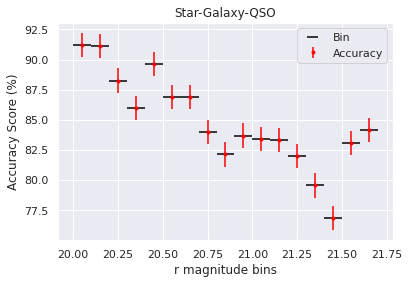

In [20]:
plt.errorbar(lower_bin_list+bin_size/2, np.array(acclist)*100, xerr=bin_size/2, fmt=" ",color="black",label="Bin")
plt.errorbar(lower_bin_list+bin_size/2, np.array(acclist)*100, yerr=0.01*100,fmt=".",color="red",label="Accuracy")
# plt.errorbar(lower_bin_list+bin_size/2, f1list, yerr=0.01,label="F1 Score")
plt.legend()
plt.title("Star-Galaxy-QSO")
plt.xlabel("r magnitude bins")
plt.ylabel("Accuracy Score (%)")
plt.savefig("type3/accuracy.pdf")


In [21]:
subdfs = pd.concat(subdflist)

In [22]:
gal_recall_list = []
gal_precision_list = []
star_recall_list = []
star_precision_list = []
qso_precision_list = []
qso_recall_list = []
for r in reportlist:
    gal_recall_list.append(r["GALAXY"]["recall"])
    gal_precision_list.append(r["GALAXY"]["precision"])
    star_recall_list.append(r["STAR"]["recall"])
    star_precision_list.append(r["STAR"]["precision"])
    qso_recall_list.append(r["QSO"]["recall"])
    qso_precision_list.append(r["QSO"]["precision"])

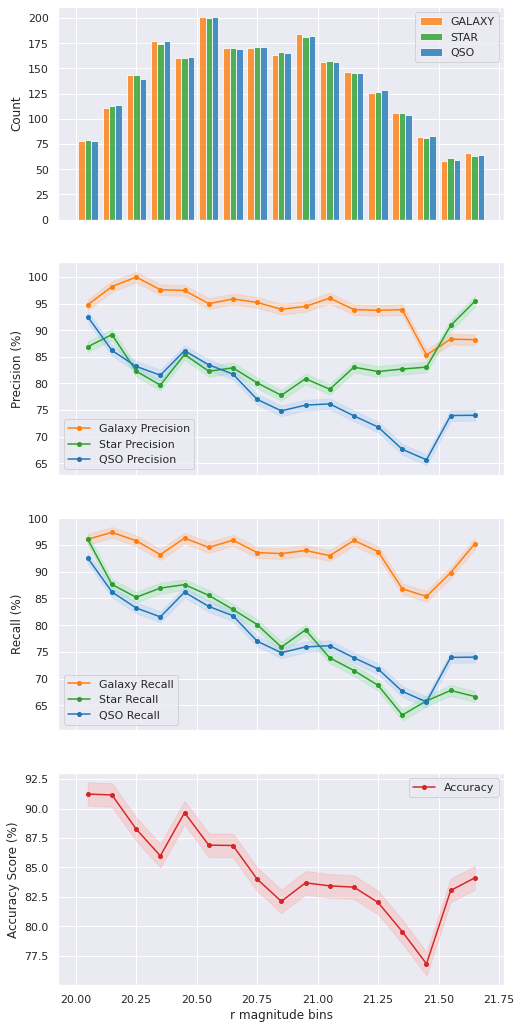

In [23]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1,sharex=True, figsize=(8,18))

galcolor = sns.color_palette("tab10")[1]
starcolor = sns.color_palette("tab10")[2]
qsocolor = sns.color_palette("tab10")[0]
acccolor = sns.color_palette("tab10")[3]
f1color = sns.color_palette("tab10")[4]

dyfit = 0.01
x_ax = lower_bin_list+bin_size/2


d1 = subdfs[subdfs["class"]=="GALAXY"]["r"]
d2 = subdfs[subdfs["class"]=="STAR"]["r"]
d3 = subdfs[subdfs["class"]=="QSO"]["r"]

ax1.hist([d1, d2, d3], color=[galcolor,starcolor, qsocolor],
         alpha=0.8, label=["GALAXY","STAR","QSO"],bins=len(lower_bin_list))
ax1.set_ylabel("Count")

ax1.legend()


y_ax1 = np.array(gal_precision_list)
y_ax2 = np.array(star_precision_list)
y_ax3 = np.array(qso_precision_list)

ax2.errorbar(x_ax, y_ax1*100,fmt="-o", ms=4, label="Galaxy Precision",color=galcolor)
ax2.fill_between(x_ax, y_ax1*100 - dyfit*100, y_ax1*100 + dyfit*100,
             color=sns.color_palette("pastel")[1], alpha=0.3)
ax2.errorbar(x_ax, y_ax2*100,fmt="-o", ms=4, label="Star Precision",color=starcolor)
ax2.fill_between(x_ax, y_ax2*100 - dyfit*100, y_ax2*100 + dyfit*100,
                 color=sns.color_palette("pastel")[2], alpha=0.3)
ax2.errorbar(x_ax, y_ax3*100,fmt="-o", ms=4, label="QSO Precision",color=qsocolor)
ax2.fill_between(x_ax, y_ax3*100 - dyfit*100, y_ax3*100 + dyfit*100,
                 color=sns.color_palette("pastel")[0], alpha=0.3)
ax2.set_ylabel("Precision (%)")
ax2.legend()



y_ax1 = np.array(gal_recall_list)
y_ax2 = np.array(star_recall_list)
y_ax3 = np.array(qso_precision_list)

ax3.errorbar(x_ax, y_ax1*100,fmt="-o", ms=4, label="Galaxy Recall",color=galcolor)
ax3.fill_between(x_ax, y_ax1*100 - dyfit*100, y_ax1*100 + dyfit*100,
             color=sns.color_palette("pastel")[1], alpha=0.3)
ax3.errorbar(x_ax, y_ax2*100,fmt="-o", ms=4, label="Star Recall",color=starcolor)
ax3.fill_between(x_ax, y_ax2*100 - dyfit*100, y_ax2*100 + dyfit*100,
             color=sns.color_palette("pastel")[2], alpha=0.3)
ax3.errorbar(x_ax, y_ax3*100,fmt="-o", ms=4, label="QSO Recall",color=qsocolor)
ax3.fill_between(x_ax, y_ax3*100 - dyfit*100, y_ax3*100 + dyfit*100,
             color=sns.color_palette("pastel")[0], alpha=0.3)
ax3.set_ylabel("Recall (%)")
ax3.legend()



y_ax1 = np.array(acclist)
y_ax2 = np.array(f1list)
ax4.errorbar(x_ax, y_ax1*100,fmt="-o", ms=4, label="Accuracy",color=acccolor)
# ax4.errorbar(x_ax, y_ax2*100,fmt="-o", ms=4, label="F1 Score",color=f1color)
ax4.fill_between(x_ax, y_ax1*100 - dyfit*100, y_ax1*100 + dyfit*100,
             color=sns.color_palette("pastel")[3], alpha=0.3)
ax4.set_ylabel("Accuracy Score (%)")
ax4.legend()

plt.xlabel("r magnitude bins")

# plt.suptitle("Star-Galaxy")
plt.savefig("type3/smallextinction.pdf")
plt.show()
